In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from matplotlib.font_manager import fontManager, FontProperties
import ptitprince as pt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
import pingouin as pg
import statsmodels.api as sm

# path = "font/seguiemj.ttf"
# fontManager.addfont(path)

# prop = FontProperties(fname=path)
# sns.set(font=prop.get_family())
# plt.rcParams['font.family'] = prop.get_family()


def get_img(name):
     path = "font/emojis/{}.png".format(name)
     im = plt.imread(path)
     return im

def offset_image(coord, name, ax, size=0.5):
    img = get_img(name)
    im = OffsetImage(img, zoom=size)
    im.image.axes = ax

    ab = AnnotationBbox(im, (coord, 0),  xybox=(0., -21.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)

def raincloud(x, y, markersize, df, order=None, hue=None):
    # adding color
    pal = sns.color_palette()
    # f, ax = plt.subplots(figsize=(5*2.5, 5*2.5))

    means = df.groupby([x])[y].mean().reindex(order)
    dodge = None
    if hue:
        means = df.groupby([x, hue])[y].mean().reindex(order)
        dodge = True
        
    sns.scatterplot(x=means.index, y=means, color='white', edgecolor='black', s=150/2, linewidth=1.5, zorder=4)

    ax = pt.half_violinplot(x=x, y=y, data=df, palette=pal, bw=.25, cut=0., linewidth=0, 
                            scale="area", width=.7, inner=None, orient='v', zorder=1, order=order, hue=hue, dodge=dodge)

    ax = sns.stripplot(x=x, y=y, data=df, palette=pal, edgecolor="white",  linewidth=1, order=order,
                       size=markersize, orient='v', zorder=2, jitter=1, alpha=0.6, hue=hue, dodge=dodge)


    ax2 = sns.pointplot(x=x, y=y, data=df, color='black',  join=False, errorbar='se', linewidth=1,
     edgecolor='black', capsize=.06, zorder=3, bw=0, order=order, hue=hue, dodge=dodge)
    
 


In [58]:
df = pd.read_csv('HUMANS/turing_60.csv')
df = df[df.prolific_id.isin(df.prolific_id.value_counts()[df.prolific_id.value_counts() == 138].index)]

print("complete =", (df.groupby('prolific_id').prolific_id.count() == 138).sum())
print("incomplete =", (df.groupby('prolific_id').prolific_id.count() != 138).sum())
print("dataset_id that are complete =", df.dataset_id.value_counts()==138)
print("dataset_id that are incomplete =", [i for i in range(77) if i not in df.dataset_id.value_counts().index])

df['correct'] = None
df['correct'] = df.correct.astype(bool)
df['agree1'] = None
df['agree1'] = df.agree1.astype(bool)
df['agree2'] = None
df['agree2'] = df.agree2.astype(bool)

df.loc[df.q_id==2, 'correct'] = df.source == df.answer
df.loc[df.q_id==1, 'agree2'] = df.answer.str.contains('Yes')
df.loc[df.q_id==0, 'agree1'] = df.answer.str.contains('Yes')

# avg.head()
print(sum(df.item_id.value_counts()))

# add correct and agree1 to all rows where item id is the same (easier to plot)
for i in df.item_id.unique():
    df.loc[df.item_id==i, 'correct'] = df[(df.item_id==i) & (df.q_id==2)].correct.values[0]
    df.loc[df.item_id==i, 'agree1'] = df[(df.item_id==i) & (df.q_id==0)].agree1.values[0]
    df.loc[df.item_id==i, 'agree2'] = df[(df.item_id==i) & (df.q_id==1)].agree2.values[0]
# df['agree1']
df['agree_both'] = df.agree1 & df.agree2
df['disagree_both'] = ~df.agree1 & ~df.agree2

complete = 64
incomplete = 0
dataset_id that are complete = 54    False
20    False
43    False
12    False
21    False
16    False
24    False
50    False
28    False
6     False
9     False
46    False
17    False
27    False
25     True
33     True
42     True
56     True
58     True
32     True
0      True
30     True
2      True
18     True
19     True
13     True
11     True
8      True
5      True
4      True
3      True
64    False
65    False
Name: dataset_id, dtype: bool
dataset_id that are incomplete = [1, 7, 10, 14, 15, 22, 23, 26, 29, 31, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 47, 48, 49, 51, 52, 53, 55, 57, 59, 60, 61, 62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
8832


/tmp/ipykernel_259619/4130090810.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


               T  dof alternative         p-val          CI95%   cohen-d  \
T-test -7.889017   63   two-sided  5.579004e-11  [-0.2, -0.12]  0.790974   

             BF10  power  
T-test  1.728e+08    1.0  
               T  dof alternative    p-val          CI95%   cohen-d   BF10  \
T-test -0.637633  126   two-sided  0.52487  [-0.06, 0.03]  0.112719  0.227   

           power  
T-test  0.096985  
               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -6.738882  126   two-sided  5.117169e-10  [-0.22, -0.12]  1.191277   

             BF10  power  
T-test  1.656e+07    1.0  
               T  dof alternative     p-val          CI95%  cohen-d   BF10  \
T-test -0.518449   63   two-sided  0.605961  [-0.04, 0.02]  0.08092  0.156   

           power  
T-test  0.097709  
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.310936   63   two-sided  0.756876  [-0.02, 0.03]  0.040385  0.144   

           power  
T-test  0.061677

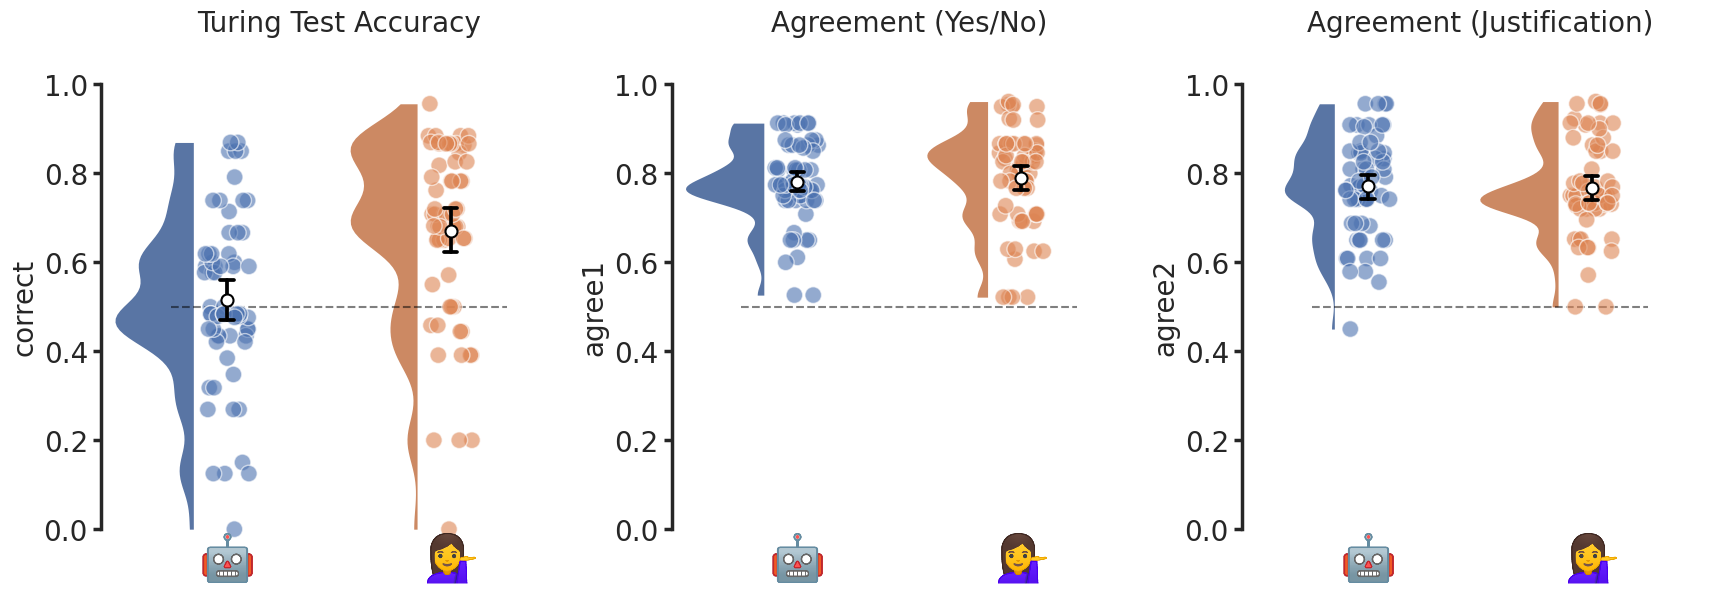

In [72]:
# prit(j)
sns.set({'figure.figsize':(23, 8), 'figure.dpi': 300, 'font.size': 16})
sns.set(
    rc={'figure.figsize':(23,6), "figure.dpi": 100, 'legend.fontsize': 20, 'axes.labelsize': 20, 'axes.titlesize': 20,
      'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# -------------------------------------------------------------------------------
# Plot 1: Turing Test 
# -------------------------------------------------------------------------------
avg = df[df.q_id==2].groupby(['prolific_id', 'source'], as_index=False).mean()
plt.subplot(1, 4, 1)
# sns.barplot(x='source', y='correct', data=avg, errorbar='se'
# sns.stripplot(x='source', y='correct', data=avg, alpha=0.5, jitter=0.1, size=15, color='black')
#
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='correct', markersize=12, df=avg, order=['AI', 'Human'])
plt.ylim(0, 1)
plt.ylim(-.1, 1.1)
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.title('Turing Test Accuracy')
plt.xticks([])
plt.gca().spines['left'].set_linewidth(2.5)
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);

# AI correct and Human correct is significantly diff
print(pg.ttest(avg[avg.source=='AI'].correct, avg[avg.source=='Human'].correct, paired=True))
n = len(avg[avg.source=='AI'].correct)
print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='AI'].correct))
print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='Human'].correct))

# -------------------------------------------------------------------------------
# Plot 2: Agreement 1
# -------------------------------------------------------------------------------
avg = df[df.q_id==0].groupby(['prolific_id', 'source'], as_index=False).mean()
plt.subplot(1, 4, 2)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='agree1', markersize=12, df=avg, order=['AI', 'Human'])
# sns.barplot(x='source', y='agree1', data=avg, errorbar='se')
# sns.stripplot(x='source', y='agree1', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
plt.ylim(0, 1)
plt.ylim(-.1, 1.1)
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.title('Agreement (Yes/No)')
plt.xticks([])
plt.gca().spines['left'].set_linewidth(2.5)
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
# AI agree1 and Human agree1 is significantly diff
print(pg.ttest(avg[avg.source=='AI'].agree1, avg[avg.source=='Human'].agree1, paired=True))
# n = len(avg[avg.source=='AI'].correct)
# print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='AI'].correct))
# print(pg.ttest(x=np.ones(n) * .5, y=avg[avg.source=='Human'].correct))




# -------------------------------------------------------------------------------
# Plot 3: Agreement 2
# -------------------------------------------------------------------------------
avg = df[df.q_id==1].groupby(['prolific_id', 'source'], as_index=False).mean()
plt.subplot(1, 4, 3)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='agree2', markersize=12, df=avg, order=['AI', 'Human'])
# sns.barplot(x='source', y='agree2', data=avg, errorbar='se')
# sns.stripplot(x='source', y='agree2', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
plt.ylim(-.1, 1.1)
plt.title('Agreement (Justification)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks([])
# AI agree2 and Human agree2 is significantly diff
print(pg.ttest(avg[avg.source=='AI'].agree2, avg[avg.source=='Human'].agree2, paired=True))


# -------------------------------------------------------------------------------
# Plot 4: RT
# -------------------------------------------------------------------------------
#avg = df.groupby(['prolific_id', 'source'], as_index=False).mean()
#plt.subplot(1, 4, 4)
## plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
## plt.plot([-1, 2], [0.5, 0.5], '--', color='black', alpha=0.5)
##sns.barplot(x='source', y='rt', data=avg, errorbar='se')
##sns.stripplot(x='source', y='rt', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
#raincloud(x='source', y='rt', markersize=12, df=avg, order=['AI', 'Human'])
#plt.ylim(0, 100000)
#plt.title('RT (ms)')
#plt.xlabel('')
#sns.despine(offset=10, trim=True, bottom=True);
#plt.xticks([])
#plt.gca().spines['left'].set_linewidth(2.5)
#for i, c in enumerate(avg.source.unique()):
#    offset_image(i, c, plt.gca(), size=0.3)
#
plt.tight_layout()

          n         r          CI95%     p-val   BF10     power
pearson  63  0.131245  [-0.12, 0.37]  0.305216  0.263  0.177207
                            OLS Regression Results                            
Dep. Variable:                 agree1   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.069
Date:                Sat, 28 Jan 2023   Prob (F-statistic):              0.305
Time:                        20:27:11   Log-Likelihood:                 63.376
No. Observations:                  63   AIC:                            -122.8
Df Residuals:                      61   BIC:                            -118.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

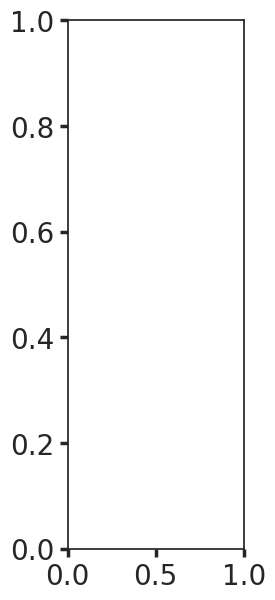

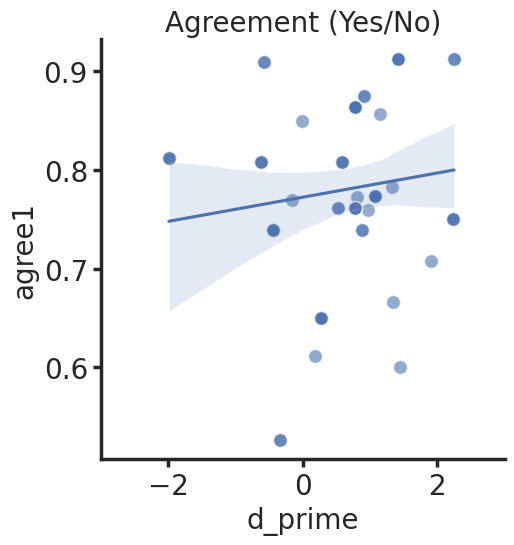

          n         r        CI95%     p-val    BF10     power
pearson  63  0.408829  [0.18, 0.6]  0.000879  35.066  0.923175
                            OLS Regression Results                            
Dep. Variable:                 agree2   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     12.24
Date:                Sat, 28 Jan 2023   Prob (F-statistic):           0.000879
Time:                        20:27:12   Log-Likelihood:                 54.952
No. Observations:                  63   AIC:                            -105.9
Df Residuals:                      61   BIC:                            -101.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----

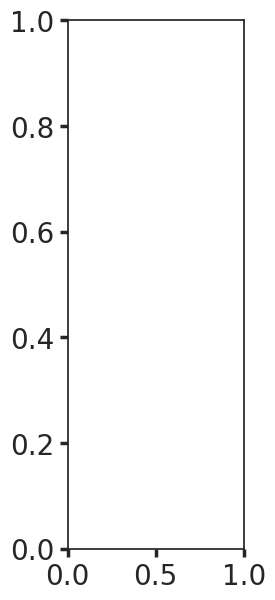

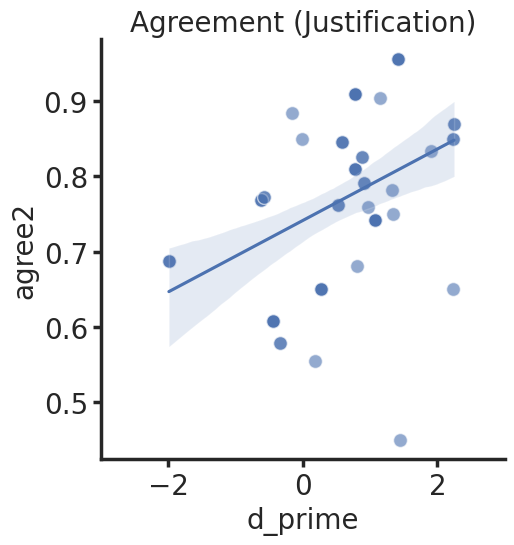

In [149]:
import scipy.stats as stats

sns.set({'figure.figsize':(5, 7), 'figure.dpi': 100, 'font.size': 13})
sns.set_style('ticks')
sns.color_palette('deep')


false = pd.DataFrame()
hits = pd.DataFrame()

labels = ['id', 'agree1', 'agree2']
labels = ['id']
titles = ['Agreement (Yes/No)', 'Agreement (Justification)']

false['id'] = 1 - df[(df.source=='Human') & (df.q_id == 2)].groupby('prolific_id', as_index=False).mean().correct
hits['id'] = df[(df.source=='AI') & (df.q_id == 2)].groupby('prolific_id', as_index=False).mean().correct
false['agree1'] = 1 - df[(df.source=='Human') & (df.q_id == 0)].groupby('prolific_id', as_index=False).mean().agree1
hits['agree1'] = df[(df.source=='AI') & (df.q_id == 0)].groupby('prolific_id', as_index=False).mean().agree1
false['agree2'] = 1 - df[(df.source=='Human') & (df.q_id == 1)].groupby('prolific_id', as_index=False).mean().agree2
hits['agree2'] = df[(df.source=='AI') & (df.q_id == 1)].groupby('prolific_id', as_index=False).mean().agree2

d = []
for i in range(false['id'].shape[0]):
    d.append({ 'agree1': hits['agree1'].values[i], 'agree2': hits['agree2'].values[i], 'd_prime': float(stats.norm.ppf(hits['id'].values[i]) - stats.norm.ppf(false['id'].values[i]))})

d = pd.DataFrame(d)# plt.subplot(1, 4, 1)
d = d[~d.isin([np.nan, np.inf, -np.inf]).any(1)]
# sns.barplot(x='cond', y='d_prime', data=d, errorbar='se')
# sns.stripplot(x='cond', y='d_prime', data=d, alpha=0.5, jitter=0.1, size=15, color='black')
# plt.ylim(0, 1)
# plt.xticks(range(2), ('', ''))
# plt.title('Signal sensitivity')
# for i, c in enumerate(avg.source.unique()):
    # offset_image(i, c, plt.gca(), size=0.3
count = 0
d['d_prime'] = d['d_prime'].astype(float)
d['agree1'] = d['agree1'].astype(float)
for agree in ('agree1', 'agree2'):
    count += 1
    plt.subplot(1, 2, count)
    sns.lmplot(x='d_prime', y=agree, data=d, scatter_kws={'alpha': 0.6, 's': 100, 'edgecolor': 'white'})
# sns.despine(offset=10, trim=True)
    plt.gca().spines['left'].set_linewidth(2.5)
    plt.gca().spines['bottom'].set_linewidth(2.5)
    plt.xlim([-3, 3])
    plt.title(titles[count-1])
    print(pg.corr(d['d_prime'], d[agree]))
    print(sm.formula.ols(f'{agree} ~ d_prime', data=d).fit().summary())

    
    plt.show()




<AxesSubplot:ylabel='d_prime'>

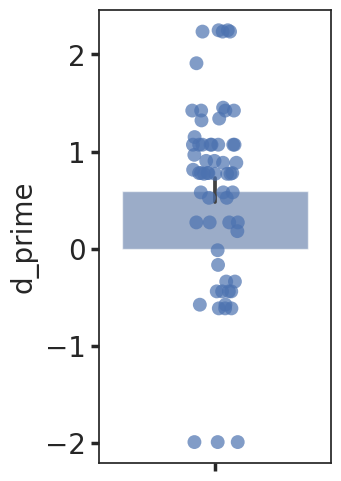

In [150]:
sns.set({'figure.figsize':(3, 6), 'figure.dpi': 100, 'font.size': 13})
sns.set_style('ticks')
sns.barplot(y='d_prime', data=d, ci=68, alpha=.6)
sns.stripplot(y='d_prime', data=d, size=10, edgecolor='white', alpha=.7)

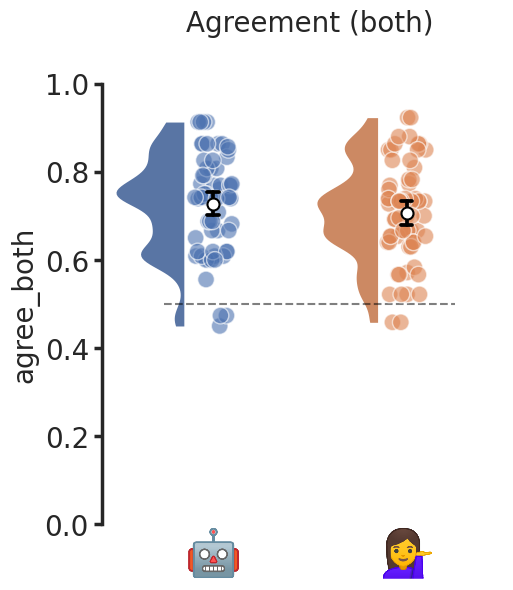

In [117]:
sns.set_style('ticks')
sns.color_palette('deep')
# -------------------------------------------------------------------------------
# Plot: Consistency agreement
# -------------------------------------------------------------------------------
avg = df[df.q_id.isin([0])].groupby(['prolific_id', 'source'], as_index=False).mean()
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
# sns.barplot(x='source', y='agree2', data=avg, errorbar='se')
# sns.stripplot(x='source', y='agree2', data=avg, color='black', alpha=0.5, jitter=0.1, size=15)
plt.ylim(-.1, 1.1)
plt.title('Agreement (both)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks([])
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)



             Source        SS  ddof1  ddof2        MS          F     p-unc  \
0            source  0.042591      1     62  0.042591   1.457372  0.231934   
1           correct  0.191409      1     62  0.191409   8.626604  0.004645   
2  source * correct  0.783378      1     62  0.783378  17.762730  0.000083   

   p-GG-corr       ng2  eps  
0   0.231934  0.005388  1.0  
1   0.004645  0.023767  1.0  
2   0.000083  0.090612  1.0  
             Source        SS  ddof1  ddof2        MS          F     p-unc  \
0            source  0.046281      1     62  0.046281   2.479753  0.120410   
1           correct  0.156205      1     62  0.156205   5.053989  0.028135   
2  source * correct  1.026314      1     62  1.026314  21.129702  0.000022   

   p-GG-corr       ng2  eps  
0   0.120410  0.005548  1.0  
1   0.028135  0.018482  1.0  
2   0.000022  0.110096  1.0  


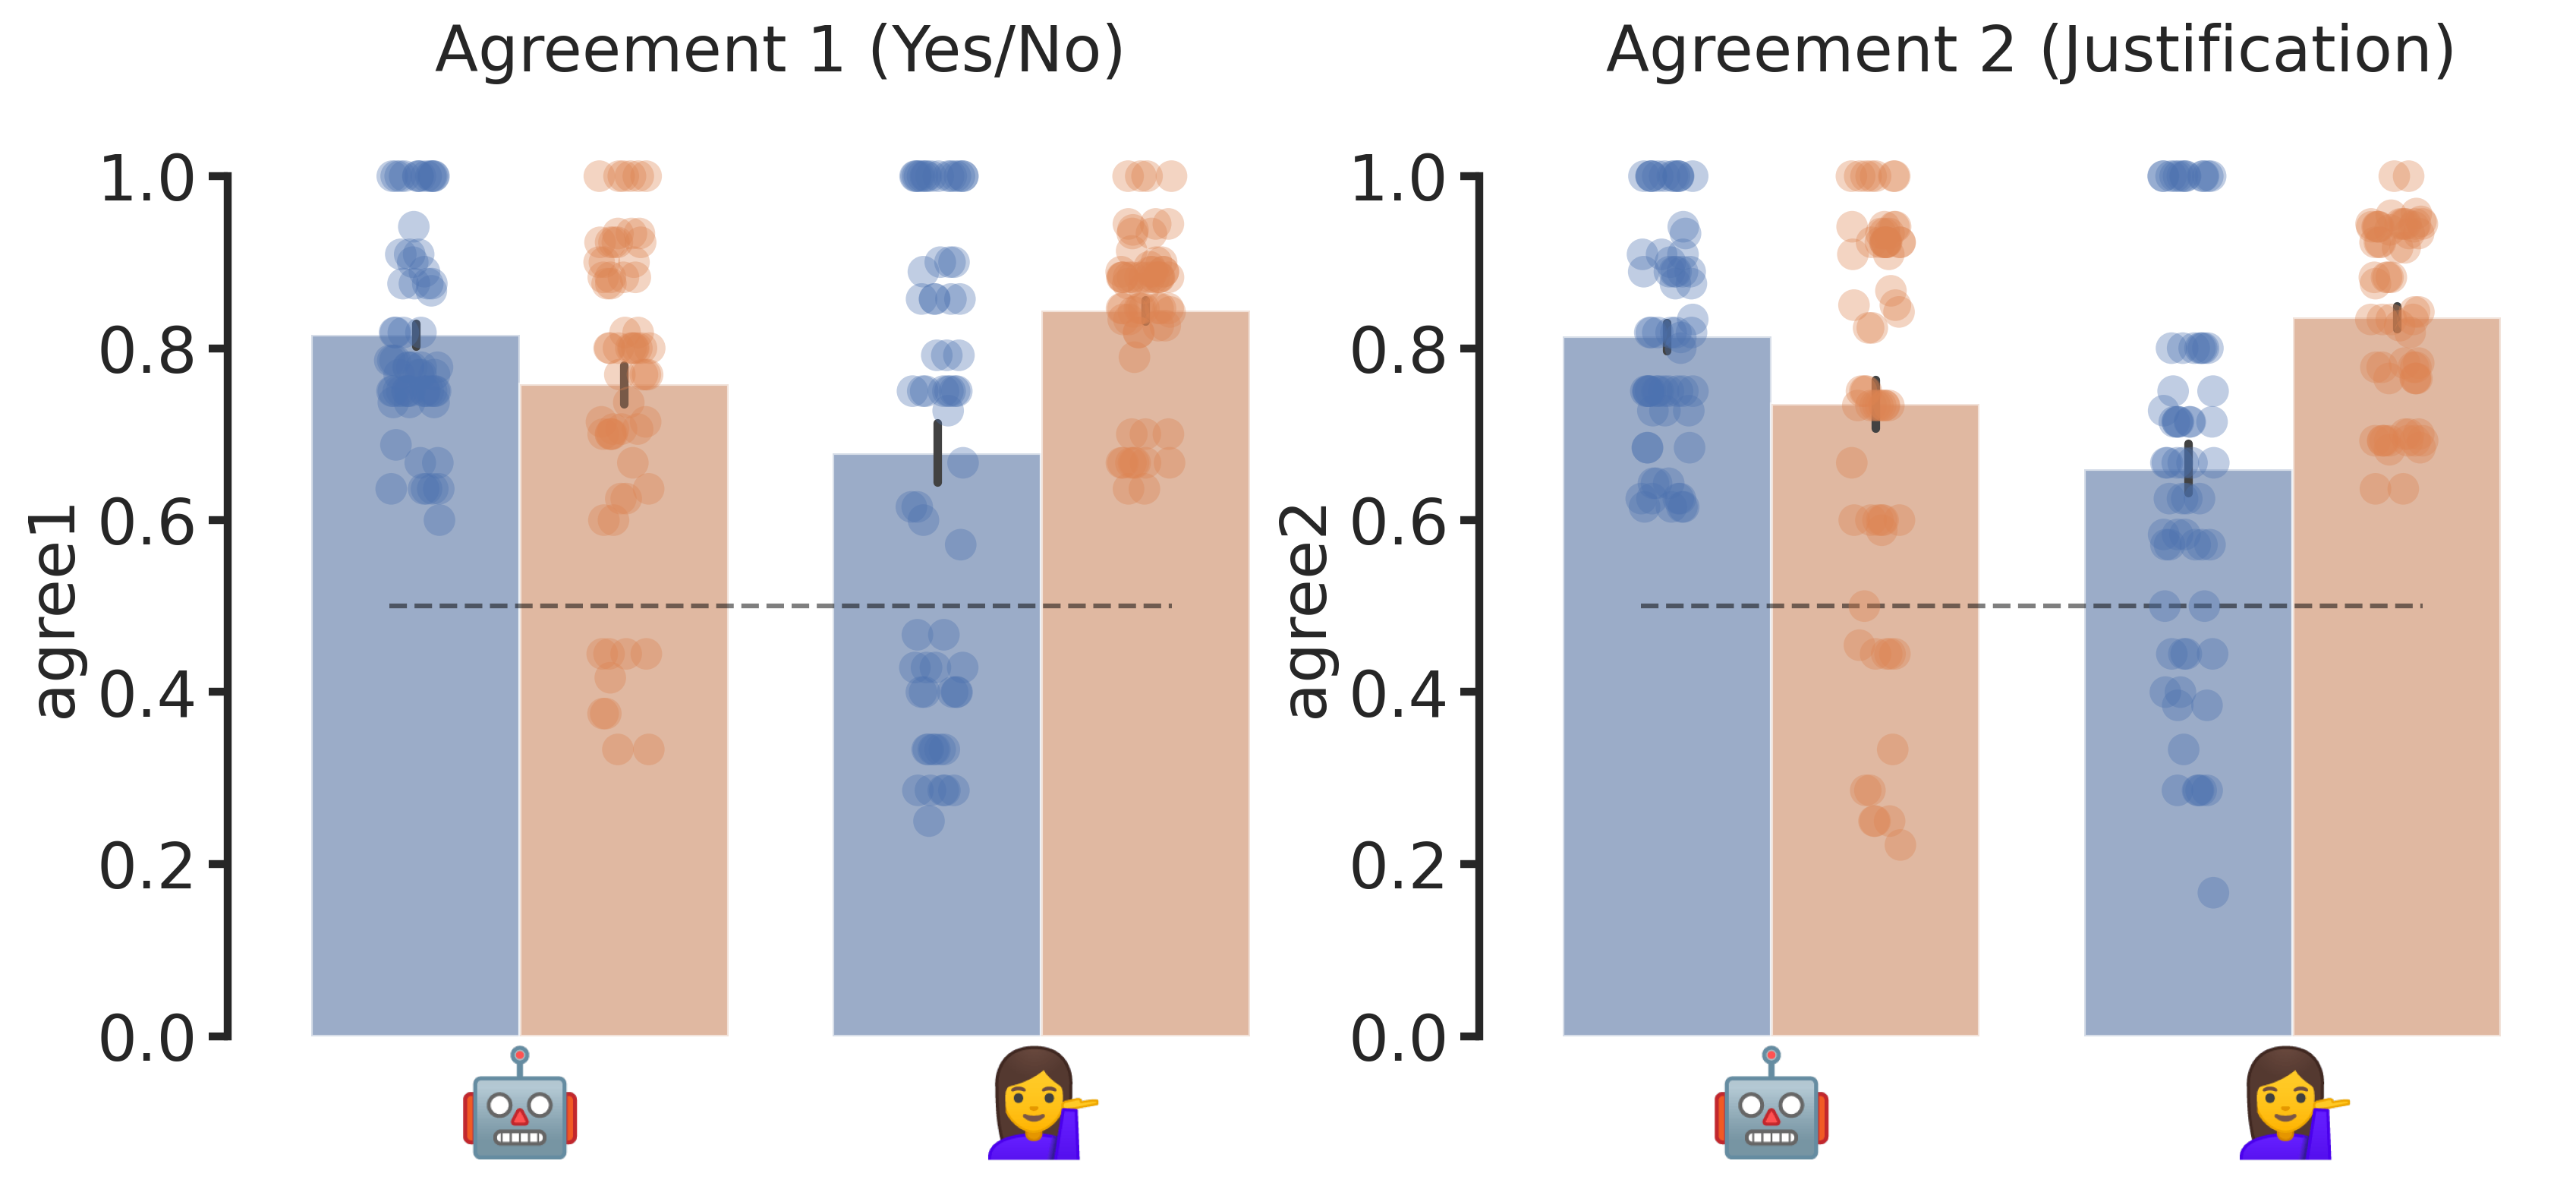

In [137]:
sns.set(
    rc={'figure.figsize':(13,6), "figure.dpi": 300, 'legend.fontsize': 20, 'axes.labelsize': 20, 'axes.titlesize': 20,
      'xtick.labelsize': 20, 'ytick.labelsize': 20, 'font.family': 'sans-serif',
      'font.sans-serif': 'Arial', 'text.usetex': False})
# set S2 as default style
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5


# sns.set_palette('Set2')
sns.set_palette('deep')
sns.set_style("ticks")

# -------------------------------------------------------------------------------
# Plot:  agreement 1 per correct and source + anova
# -------------------------------------------------------------------------------

avg = df.groupby(['prolific_id', 'source', 'correct'], as_index=False).mean()
plt.subplot(1, 2, 1)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='source', y='agree1', data=avg, ci=68, alpha=0.6, hue='correct')
sns.stripplot(x='source', y='agree1', data=avg, alpha=0.35, jitter=0.1, size=10, dodge=True, hue='correct')
plt.ylim(-.1, 1.1)
plt.title('Agreement 1 (Yes/No)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.legend([], [], frameon=False)
print(pg.rm_anova(data=avg, dv='agree1', within=['source', 'correct'], subject='prolific_id', detailed=True))


# -------------------------------------------------------------------------------
# Plot:  agreement 2 per correct and source + anova
# -------------------------------------------------------------------------------
plt.subplot(1, 2, 2)
plt.plot([-0.25, 1.25], [0.5, 0.5], '--', color='black', alpha=0.5)
# raincloud(x='source', y='agree_both', markersize=12, df=avg, order=['AI', 'Human'])
sns.barplot(x='source', y='agree2', data=avg, ci=68, alpha=0.6, hue='correct')
sns.stripplot(x='source', y='agree2', data=avg, alpha=0.35, jitter=0.1, size=10, dodge=True, hue='correct')
plt.ylim(-.1, 1.1)
plt.title('Agreement 2 (Justification)')
plt.xticks(range(2), ('', ''))
plt.xlabel('')
plt.xticks([])
for i, c in enumerate(avg.source.unique()):
    offset_image(i, c, plt.gca(), size=0.3)
sns.despine(offset=10, trim=True, bottom=True);
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.legend([], [], frameon=False)
print(pg.rm_anova(data=avg, dv='agree2', within=['source', 'correct'], subject='prolific_id', detailed=True))